In [ ]:
!pip install pandas==0.25.3
!pip install matplotlib==3.1.2

In [1]:
import requests
import pandas as pd
import numpy as np

In [2]:
# Get all driver information for the last 10 seasons
seasons = ['2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']

for season in seasons:
    
    # Make request for drivers
    r = requests.get(f'http://ergast.com/api/f1/{season}/drivers.json').json()
    drivers = r['MRData']['DriverTable']['Drivers']
    
    for driver in drivers:
        driver['season'] = season
        
    # Merge DataFrames
    try:
        df_drivers = pd.concat([df_drivers, pd.DataFrame(drivers)], sort=False)
        
    except:
        df_drivers = pd.DataFrame(drivers)
        
# Prettify
cols = ['id','code','url','first_name','last_name','birthday','nationality','season','number']
df_drivers.columns = cols

In [3]:
# Get all races in the season
for season in seasons:
    
    # Make request for drivers
    r = requests.get(f'http://ergast.com/api/f1/{season}.json').json()
    races = r['MRData']['RaceTable']['Races']
    
    # Merge DataFrames
    try:
        df_races = pd.concat([df_races, pd.DataFrame(races)], sort=False)
        
    except:
        df_races = pd.DataFrame(races)
            
# Prettify
df_races.columns = ['season','round','url','race_name','circuit','date','time']

In [5]:
# Get all race results per race
for col, row in df_races.iterrows():
    
    # Make request
    season_round = row['round']
    season = row['season']
    r = requests.get(f'http://ergast.com/api/f1/{season}/{season_round}/results.json').json()
    results = r['MRData']['RaceTable']['Races'][0]['Results']
    
    # Extracting the data - could use json.normalize
    for result in results:
        result['season'] = row['season']
        result['round'] = row['round']
        result['id'] = result['Driver']['driverId']
        result['constructor'] = result['Constructor']['constructorId']
        
        # Get the total time, if DNF then None
        try:
            result['millis'] = result['Time']['millis']
            result['time'] = result['Time']['time']
        
        except:
            result['millis'] = None
            result['time'] = None
    
        # Get 
        try:
            result['fl_rank'] = result['FastestLap']['rank']
            result['f1_lap'] = result['FastestLap']['lap']
            result['fl_time'] = result['FastestLap']['Time']['time']
            result['fl_speed'] = result['FastestLap']['AverageSpeed']['speed']
            
        except:
            result['fl_rank'] = None
            result['f1_lap'] = None
            result['fl_time'] = None
            result['fl_speed'] = None
            
    # Merge DataFrames
    try:
        df_results = pd.concat([df_results, pd.DataFrame(results)], sort=False)
        
    except:
        df_results = pd.DataFrame(results)
        
# Prettify
del df_results['Time']
del df_results['FastestLap']
del df_results['Driver']
del df_results['Constructor']

In [6]:
df_results = df_results.rename(columns={'positionText':'position_text'})

# Derived columns

#### DNF

In [7]:
df = df_results.copy().reset_index()
df.head()

,index,number,position,position_text,points,grid,laps,status,season,round,id,constructor,millis,time,fl_rank,f1_lap,fl_time,fl_speed
0,0,8,1,1,25,3,49,Finished,2010,1,alonso,ferrari,5960396,1:39:20.396,1,45,1:58.287,191.706
1,1,7,2,2,18,2,49,Finished,2010,1,massa,ferrari,5976495,+16.099,5,38,1:59.732,189.392
2,2,2,3,3,15,4,49,Finished,2010,1,hamilton,mclaren,5983578,+23.182,4,42,1:59.560,189.665
3,3,5,4,4,12,1,49,Finished,2010,1,vettel,red_bull,5999195,+38.799,12,32,2:00.218,188.627
4,4,4,5,5,10,5,49,Finished,2010,1,rosberg,mercedes,6000609,+40.213,13,45,2:00.236,188.599


In [8]:
def is_dnf(status):
    
    if status in ('Finished','+1 Lap', '+2 Laps', '+3 Laps'):
        return False
    
    else:
        return True

In [9]:
df['dnf'] = df['status'].apply(is_dnf)

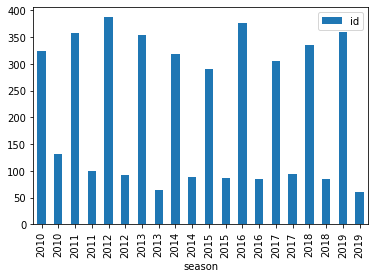

In [10]:
df.groupby(['season','dnf']).id.count().reset_index().plot.bar(x='season', y='id')

#### Average age

In [11]:
# Join race date onto results
df_races['date'] = pd.to_datetime(df_races['date'])
df = pd.merge(df, df_races[['season','round','date','race_name']], how='left', on=['season','round'])

In [12]:
# Join drivers birthday and nationality onto results
df_drivers['birthday'] = pd.to_datetime(df_drivers['birthday'])
cols = ['id','season','birthday','nationality']
df = pd.merge(df, df_drivers[cols], how='left', on=['id','season'])                                                                                                                                                                                                             

In [13]:
# Create age per driver per result
df['age'] = (df['date'] - df['birthday'])/np.timedelta64(1,'Y')

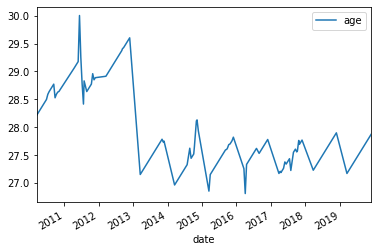

In [14]:
df.groupby('date').age.mean().reset_index().plot(kind='line', x='date',y='age')

#### Trend in fastest race in Australia

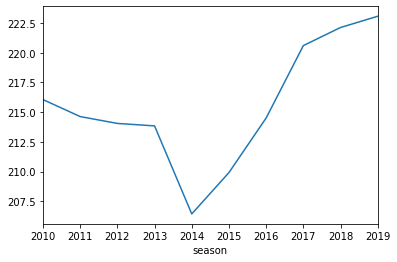

In [15]:
df['fl_speed'] = df['fl_speed'].astype('float')
df.query('race_name == "Australian Grand Prix"').groupby('season').fl_speed.max().plot.line(x='season',y='fl_speed')

#### To win ratios

In [16]:
df['grid'] = df['grid'].astype(int)
df['position'] = df['position'].astype(int)

In [17]:
# Pole to win
df.loc[df.query('grid == 1 & position == 1').index, 'pole_to_win'] = 1
df['pole_to_win'] = df['pole_to_win'].fillna(0)

# Second to win
df.loc[df.query('grid == 2 & position == 1').index, 'second_to_win'] = 1
df['second_to_win'] = df['second_to_win'].fillna(0)

# Third to win
df.loc[df.query('grid == 3 & position == 1').index, 'third_to_win'] = 1
df['third_to_win'] = df['third_to_win'].fillna(0)

In [18]:
# Calculating ratios
df_ratios = df.query('position == 1').groupby('season')[['pole_to_win','second_to_win','third_to_win']]\
    .agg(['count', 'sum']).reset_index()

df_ratios['pole'] = df_ratios['pole_to_win']['sum']/df_ratios['pole_to_win']['count']
df_ratios['second'] = df_ratios['second_to_win']['sum']/df_ratios['second_to_win']['count']
df_ratios['third'] = df_ratios['third_to_win']['sum']/df_ratios['third_to_win']['count']
df_ratios

season pole_to_win       second_to_win      third_to_win           pole  \
               count   sum         count  sum        count  sum             
0   2010          19   8.0            19  6.0           19  3.0  0.421053   
1   2011          19   9.0            19  6.0           19  3.0  0.473684   
2   2012          20  10.0            20  6.0           20  1.0  0.500000   
3   2013          19  10.0            19  6.0           19  1.0  0.526316   
4   2014          19   9.0            19  4.0           19  2.0  0.473684   
5   2015          19  12.0            19  6.0           19  1.0  0.631579   
6   2016          21  13.0            21  5.0           21  1.0  0.619048   
7   2017          20  11.0            20  4.0           20  3.0  0.550000   
8   2018          21  10.0            21  6.0           21  2.0  0.476190   
9   2019          21   8.0            21  8.0           21  5.0  0.380952   

     second     third  
                       
0  0.315789  0.157895  
1  0.315789  0.157895  
2  0.300000  0.050000  
3  0.315789  0.052632  
4  0.210526  0.105263  
5  0.315789  0.052632  
6  0.238095  0.047619  
7  0.200000  0.150000  
8  0.285714  0.095238  
9  0.380952  0.238095

#### Difference between F1 and F1.5

In [20]:
df['millis'] = df['millis'].fillna(0).astype(int)
df_times = df.query('millis > 0').groupby(['season','round']).millis.min().reset_index()
df_times.columns = ['season','round','millis_winner']
df = pd.merge(df, df_times, how='left', on=['season','round'])

In [28]:
df['millis_delta'] = df['millis'] - df['millis_winner']
df['millis_ratio'] = df['millis']/df['millis_winner']

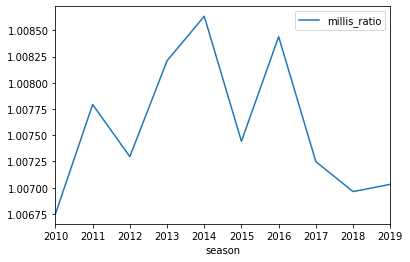

In [70]:
df.query('millis_delta > 0').groupby(['season']).millis_ratio.mean().reset_index()\
    .plot(x='season',y='millis_ratio')

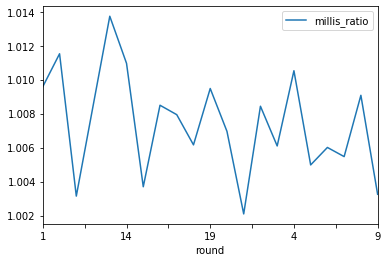

In [71]:
df.query('millis_delta > 0 & season == "2019"').groupby(['round']).millis_ratio.mean().reset_index().plot(x='round',y='millis_ratio')

In [96]:
def is_top_3(row):
    
    if row['season'] in ('2010','2011','2012') and row['constructor'] in ('mclaren','red_bull','ferrari'):
        return True
    
    elif row['constructor'] in ('ferrari','red_bull','mercedes'):
        return True
    
    else:
        return False

In [97]:
df['top_3'] = df.apply(is_top_3, axis=1)

AttributeError: 'AxesSubplot' object has no attribute 'line'

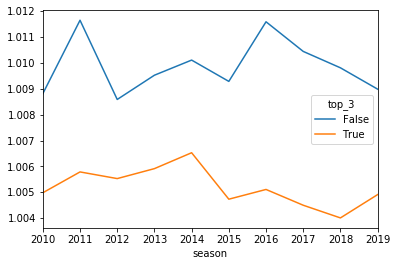

In [99]:
df.query('millis_delta > 0').groupby(['season','top_3']).millis_ratio.mean().reset_index()\
    .pivot(index='season',columns='top_3',values='millis_ratio').plot().line(x='season',y='millis_ratio')